# Performance analysis

In this notebook all the results obtained will be reported, with particular reference to the best configuration for each model.

## Imports

In [41]:
import os.path

import pandas as pd

from src.utils.const import MODEL_RESULTS_CSV, NETWORK_RESULT_CSV
from src.utils.util_notebook import (summary_statistics_model, calculate_statistics_sklearn, find_max_f1_cfg,
                                     calculate_statistics_mlp_train, find_best_conf, add_value_array)
from src.visualization.visualize import barplot_multiple_columns

### Useful path to data

In [42]:
RESULTS_FOLDER = os.path.join('..', MODEL_RESULTS_CSV)
MLP_RESULTS_FOLDER = os.path.join('..', NETWORK_RESULT_CSV)

## Read output csv

In [43]:
mlp_all = pd.read_csv(os.path.join(MLP_RESULTS_FOLDER, 'out_mlp_all.csv'))

svm_res = pd.read_csv(os.path.join(RESULTS_FOLDER, 'best_out_svm.csv'))
naive_res = pd.read_csv(os.path.join(RESULTS_FOLDER, 'best_out_naive_bayes.csv'))
tree_res = pd.read_csv(os.path.join(RESULTS_FOLDER, 'best_out_tree_based.csv'))

svm_val = pd.read_csv(os.path.join(RESULTS_FOLDER, 'out_grid_svm.csv'))
naive_val = pd.read_csv(os.path.join(RESULTS_FOLDER, 'out_grid_naive_bayes.csv'))
tree_val = pd.read_csv(os.path.join(RESULTS_FOLDER, 'out_grid_tree_based.csv'))

## Initialize output DataFrame

In [44]:
df_test_metric = pd.DataFrame()
df_train_metric = pd.DataFrame()

## Work with results

### Scikit-learn models

#### RandomForestClassifier

In [45]:
model_samples = tree_val[tree_val['model'] == 'random_forest_classifier']
cfg_random_forest_train = find_max_f1_cfg(model_samples, scikit=True)
dict_random_forest_train = find_best_conf(cfg_random_forest_train, model_samples, scikit=True)

df_train_metric = summary_statistics_model(df_train_metric, dict_random_forest_train, 'Random forest classifier',
                                           train=True, scikit=True)

res_random_forest = calculate_statistics_sklearn(tree_res, 'random_forest_classifier')
df_test_metric = summary_statistics_model(df_test_metric, res_random_forest, 'Random forest classifier')

Best configuration Random forest classifier mean metrics:
train f1: 0.962764480256733 ±0.0014806329107555883
validation f1: 0.7536210374072028 ±0.0017806481858836031

Best configuration Random forest classifier mean metrics:
f1_score: 0.7581677986121885 ±0.004976038357881232
loss: 0.2413485154615021 ±0.005052478690934511
acc: 0.758651484538498 ±0.005052478690934483

Best hyperparams configuration:
["{'model__max_depth': 10, 'model__max_features': 'sqrt', 'model__n_estimators': 700}"]


#### DecisionTreeClassifier

In [46]:
model_samples = tree_val[tree_val['model'] == 'decision_tree_classifier'].reset_index()
cfg_decision_tree_train = find_max_f1_cfg(model_samples, scikit=True)
dict_decision_tree_train = find_best_conf(cfg_decision_tree_train, model_samples, scikit=True)

df_train_metric = summary_statistics_model(df_train_metric, dict_decision_tree_train, 'Decision tree classifier',
                                           train=True, scikit=True)

res_decision_tree = calculate_statistics_sklearn(tree_res, 'decision_tree_classifier')
df_test_metric = summary_statistics_model(df_test_metric, res_decision_tree, 'Decision tree classifier')

Best configuration Decision tree classifier mean metrics:
train f1: 0.7962856543421747 ±0.0063482908135318655
validation f1: 0.664387756599635 ±0.0016535531223144722

Best configuration Decision tree classifier mean metrics:
f1_score: 0.6692881756512793 ±0.006830406648158318
loss: 0.3316353570225056 ±0.006547056860119308
acc: 0.6683646429774944 ±0.006547056860119308

Best hyperparams configuration:
["{'model__criterion': 'gini', 'model__max_depth': 10}"]


#### GaussianNB

In [47]:
model_samples = naive_val[naive_val['model'] == 'gaussian_nb'].reset_index()
cfg_gaussian_train = find_max_f1_cfg(model_samples, scikit=True)
dict_gaussian_train = find_best_conf(cfg_gaussian_train, model_samples, scikit=True)

df_train_metric = summary_statistics_model(df_train_metric, dict_gaussian_train, 'GaussianNB',
                                           train=True, scikit=True)

res_gaussian_nb = calculate_statistics_sklearn(naive_res, 'gaussian_nb')
df_test_metric = summary_statistics_model(df_test_metric, res_gaussian_nb, 'GaussianNB')

Best configuration GaussianNB mean metrics:
train f1: 0.5112353510329939 ±0.0024729441989068935
validation f1: 0.45375936744229006 ±0.002407018531210031

Best configuration GaussianNB mean metrics:
f1_score: 0.4507531837150223 ±0.013700268878737097
loss: 0.5496313276745051 ±0.01314559404282683
acc: 0.45036867232549493 ±0.013145594042826838

Best hyperparams configuration:
["{'model__var_smoothing': 1.873817422860383e-06}"]


#### SVM

In [48]:
model_samples = svm_val[svm_val['model'] == 'svc'].reset_index()
cfg_svm_train = find_max_f1_cfg(model_samples, scikit=True)
dict_svm_train = find_best_conf(cfg_svm_train, model_samples, scikit=True)

df_train_metric = summary_statistics_model(df_train_metric, dict_svm_train, 'SVM',
                                           train=True, scikit=True)

res_svm = calculate_statistics_sklearn(svm_res, 'svc')
df_test_metric = summary_statistics_model(df_test_metric, res_svm, 'SVM')

Best configuration SVM mean metrics:
train f1: 0.9769132079345578 ±0.0009694186186474346
validation f1: 0.8287437828389359 ±0.0016284238655505819

Best configuration SVM mean metrics:
f1_score: 0.8280352920981382 ±0.00386151531691321
loss: 0.17137002170872698 ±0.0038298149122526137
acc: 0.8286299782912729 ±0.003829814912252616

Best hyperparams configuration:
["{'model__C': 100, 'model__gamma': 0.01, 'model__kernel': 'rbf'}"]


### MovieNet (MLP)

In [49]:
best_cfg = find_max_f1_cfg(mlp_all)
print(f'Indices of the best configurations: {best_cfg}')

Indices of the best configurations: [0. 1. 2. 3.]


In [50]:
res_mlp_train = calculate_statistics_mlp_train(3, mlp_all)
df_train_metric = summary_statistics_model(df_train_metric, res_mlp_train, 'MLP', train=True)

res_mlp = find_best_conf(best_cfg, mlp_all)
df_test_metric = summary_statistics_model(df_test_metric, res_mlp, "MLP")

Best configuration MLP mean metrics:
train f1: 0.8755459737044162 ±0.0019265183510115194
validation f1: 0.7959136321829858 ±0.0008824929662534333

Best configuration MLP mean metrics:
f1_score: 0.857635556404085 ±0.005182032674694023
loss: 0.36285945633844296 ±0.011406530906296307
acc: 0.8574580107516775 ±0.005109295770940805

Best hyperparams configuration:
input_act: LeakyReLU(negative_slope=0.01)
hidden_act: LeakyReLU(negative_slope=0.01)
hidden_size: 512
num_hidden_layers: 3
dropout: 0.2
batch_norm: False
output_fn: None
num_epochs: 200
starting_lr: 0.001
batch_size: 128
optim: <class 'torch.optim.adam.Adam'>
momentum: 0.6
weight_decay: 1e-05


### Result visualization

#### Train & Validation

In [51]:
metrics = []
y_errs = []
add_value_array(metrics, df_train_metric, 'metrics', 3)
add_value_array(y_errs, df_train_metric, 'interval', 3)

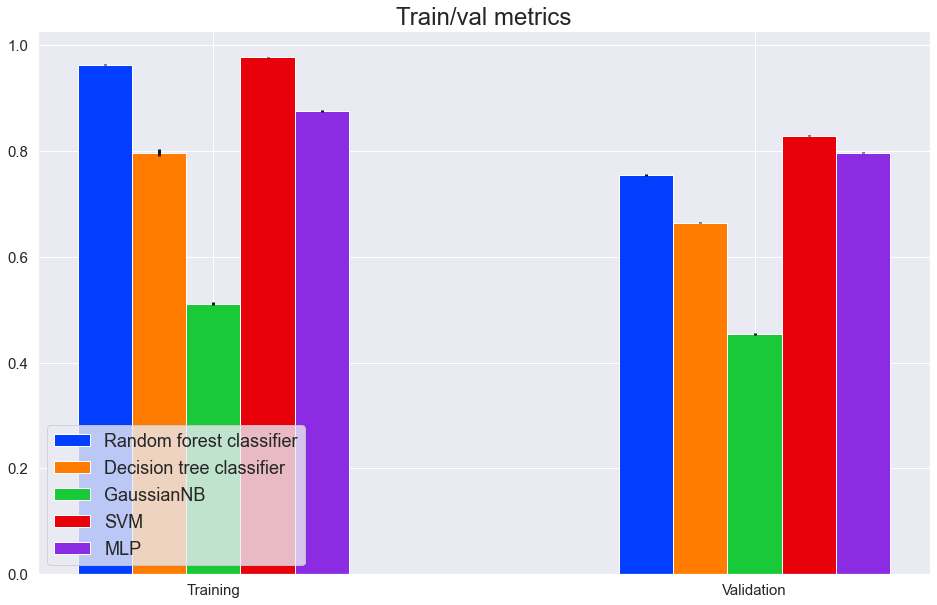

In [52]:
barplot_multiple_columns(groups=['Training', 'Validation'],
                         elements_group=df_train_metric['model'].unique(),
                         data=metrics,
                         yerr=y_errs,
                         title='Train/val metrics',
                         upper_title=False)

#### Test

Since the accuracy values are similar to f1-score values, it isn't useful show this metric in the plot.

In [53]:
df_test_metric.drop(columns=['acc_mu', 'acc_ci'], inplace=True)

In [54]:
metrics = []
y_errs = []
add_value_array(metrics, df_test_metric, 'metrics', 3)
add_value_array(y_errs, df_test_metric, 'interval', 3)

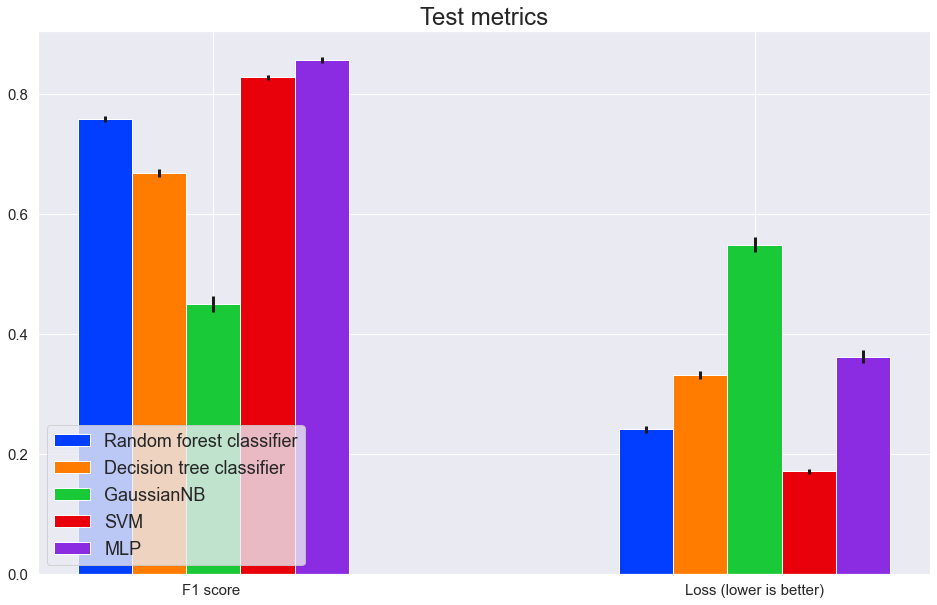

In [55]:
barplot_multiple_columns(groups=['F1 score ', 'Loss (lower is better)'],
                         elements_group=df_test_metric['model'].unique(),
                         data=metrics,
                         yerr=y_errs,
                         title='Test metrics',
                         upper_title=False)

In [56]:
svm_val[['mean_train_score', 'mean_test_score', 'params', 'fold']]

,mean_train_score,mean_test_score,params,fold
0,1.000000,0.148072,"{'model__C': 1, 'model__gamma': 1, 'model__ker...",1
1,1.000000,0.816568,"{'model__C': 1, 'model__gamma': 1, 'model__ker...",1
2,0.000604,0.000739,"{'model__C': 1, 'model__gamma': 1, 'model__ker...",1
3,0.993110,0.749463,"{'model__C': 1, 'model__gamma': 0.1, 'model__k...",1
4,1.000000,0.817094,"{'model__C': 1, 'model__gamma': 0.1, 'model__k...",1
...,...,...,...,...
130,1.000000,0.813933,"{'model__C': 100, 'model__gamma': 0.1, 'model_...",5
131,0.002366,0.001673,"{'model__C': 100, 'model__gamma': 0.1, 'model_...",5
132,1.000000,0.817986,"{'model__C': 100, 'model__gamma': 0.01, 'model...",5
133,0.993567,0.816309,"{'model__C': 100, 'model__gamma': 0.01, 'model...",5


In [57]:
naive_val

,Unnamed: 0,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__var_smoothing,params,split0_test_score,split1_test_score,split2_test_score,...,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score,fold,model,param_model__reg_param,param_model__tol
0,0,12.331153,1.121770,1.253826,0.172479,1.000000,{'model__var_smoothing': 1.0},0.094190,0.087993,0.083631,...,0.093299,0.088097,0.094037,0.092116,0.093044,0.003092,1,gaussian_nb,NaN,NaN
1,1,12.664096,1.099654,1.616183,0.215050,0.811131,{'model__var_smoothing': 0.8111308307896871},0.098948,0.094692,0.088642,...,0.103610,0.094822,0.100118,0.099157,0.099576,0.002818,1,gaussian_nb,NaN,NaN
2,2,12.658410,1.082191,1.375814,0.269919,0.657933,{'model__var_smoothing': 0.657933224657568},0.111317,0.097890,0.090294,...,0.106807,0.102122,0.114759,0.106542,0.108179,0.004259,1,gaussian_nb,NaN,NaN
3,3,14.472297,1.214514,1.272273,0.096724,0.533670,{'model__var_smoothing': 0.533669923120631},0.128565,0.115447,0.109859,...,0.126021,0.112334,0.124040,0.117280,0.121621,0.005945,1,gaussian_nb,NaN,NaN
4,4,14.547390,1.698433,1.370976,0.244746,0.432876,{'model__var_smoothing': 0.43287612810830584},0.136901,0.128857,0.121676,...,0.137397,0.130120,0.139626,0.136125,0.136179,0.003231,1,gaussian_nb,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,15,136.653247,4.698907,11.281817,0.771087,NaN,"{'model__reg_param': 0.01, 'model__tol': 0.1}",0.381736,0.395142,0.388919,...,0.765781,0.767952,0.758325,0.769353,0.765500,0.003815,5,qda,0.01,0.1000
596,16,135.401775,1.529628,10.982852,0.712494,NaN,"{'model__reg_param': 0.1, 'model__tol': 0.0001}",0.217613,0.224489,0.204404,...,0.351748,0.340684,0.349169,0.357367,0.349466,0.005405,5,qda,0.10,0.0001
597,17,139.888782,5.665210,10.249603,0.905098,NaN,"{'model__reg_param': 0.1, 'model__tol': 0.001}",0.221317,0.227343,0.201963,...,0.353188,0.339630,0.348513,0.355771,0.349484,0.005514,5,qda,0.10,0.0010
598,18,141.043225,2.570429,8.898295,0.366030,NaN,"{'model__reg_param': 0.1, 'model__tol': 0.01}",0.219690,0.224947,0.209571,...,0.356969,0.344755,0.344655,0.356076,0.350439,0.005304,5,qda,0.10,0.0100


In [58]:
df_train_metric

,model,train_score,val_score,train_ci,val_ci
0,Random forest classifier,0.962764,0.753621,0.001481,0.001781
1,Decision tree classifier,0.796286,0.664388,0.006348,0.001654
2,GaussianNB,0.511235,0.453759,0.002473,0.002407
3,SVM,0.976913,0.828744,0.000969,0.001628
4,MLP,0.875546,0.795914,0.001927,0.000882


In [59]:
df_test_metric

,model,f1_mu,loss_mu,f1_ci,loss_ci
0,Random forest classifier,0.758168,0.241349,0.004976,0.005052
1,Decision tree classifier,0.669288,0.331635,0.006830,0.006547
2,GaussianNB,0.450753,0.549631,0.013700,0.013146
3,SVM,0.828035,0.171370,0.003862,0.003830
4,MLP,0.857636,0.362859,0.005182,0.011407


In [18]:
naive_val

,Unnamed: 0,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__var_smoothing,params,split0_test_score,split1_test_score,split2_test_score,...,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score,fold,model,param_model__reg_param,param_model__tol
0,0,22.866802,1.700084,1.504663,0.166476,1.000000,{'model__var_smoothing': 1.0},0.096832,0.087092,0.089134,...,0.094904,0.092279,0.090699,0.090469,0.093544,0.003315,1,gaussian_nb,NaN,NaN
1,1,24.259131,2.073108,1.525495,0.083802,0.811131,{'model__var_smoothing': 0.8111308307896871},0.103535,0.097483,0.088497,...,0.109394,0.098575,0.096606,0.095771,0.100212,0.004898,1,gaussian_nb,NaN,NaN
2,2,19.209079,4.414410,1.444932,0.128058,0.657933,{'model__var_smoothing': 0.657933224657568},0.112784,0.105471,0.094088,...,0.111886,0.105847,0.112748,0.106754,0.109894,0.002961,1,gaussian_nb,NaN,NaN
3,3,15.251406,0.326039,1.536298,0.145697,0.533670,{'model__var_smoothing': 0.533669923120631},0.119091,0.112379,0.102830,...,0.119803,0.112605,0.125047,0.118466,0.118700,0.003999,1,gaussian_nb,NaN,NaN
4,4,16.498645,0.742761,1.689407,0.176715,0.432876,{'model__var_smoothing': 0.43287612810830584},0.135357,0.130329,0.124118,...,0.135104,0.131036,0.135471,0.133042,0.133537,0.001609,1,gaussian_nb,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,15,106.949659,2.845431,7.879046,0.320346,NaN,"{'model__reg_param': 0.01, 'model__tol': 0.1}",0.359039,0.380513,0.373667,...,0.754779,0.754982,0.752055,0.759749,0.755563,0.002500,5,qda,0.01,0.1000
596,16,103.994687,3.559797,8.094422,0.732105,NaN,"{'model__reg_param': 0.1, 'model__tol': 0.0001}",0.197867,0.199623,0.180170,...,0.328597,0.310607,0.316110,0.325863,0.320899,0.006612,5,qda,0.10,0.0001
597,17,107.485633,1.352551,7.391317,0.302079,NaN,"{'model__reg_param': 0.1, 'model__tol': 0.001}",0.202573,0.202154,0.187153,...,0.330790,0.318429,0.326605,0.334279,0.328080,0.005404,5,qda,0.10,0.0010
598,18,104.854066,2.583855,7.652043,0.783735,NaN,"{'model__reg_param': 0.1, 'model__tol': 0.01}",0.201886,0.197883,0.185849,...,0.320354,0.319463,0.323400,0.335870,0.325286,0.005967,5,qda,0.10,0.0100
